## Image quantization

Saving img.jpeg to img (4).jpeg


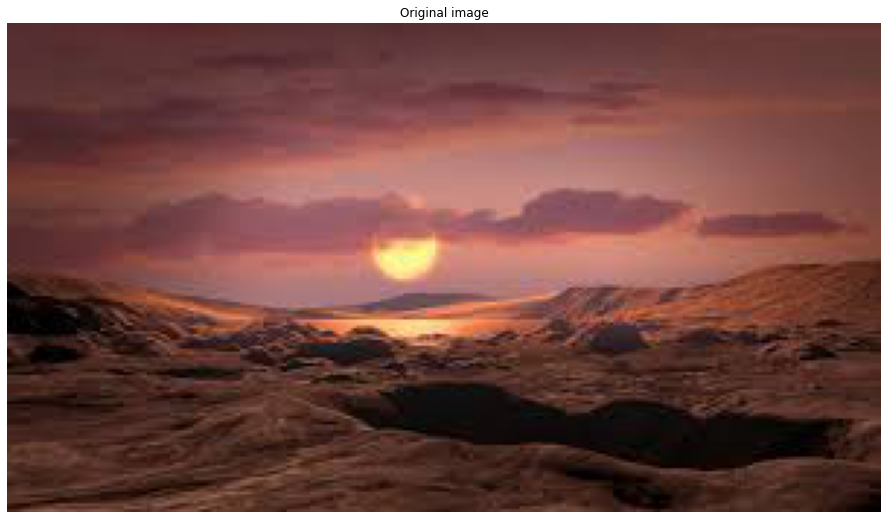

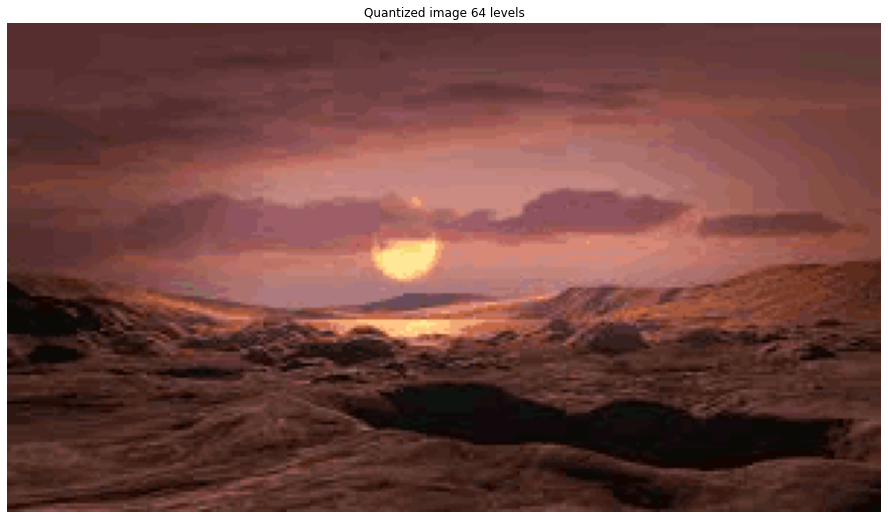

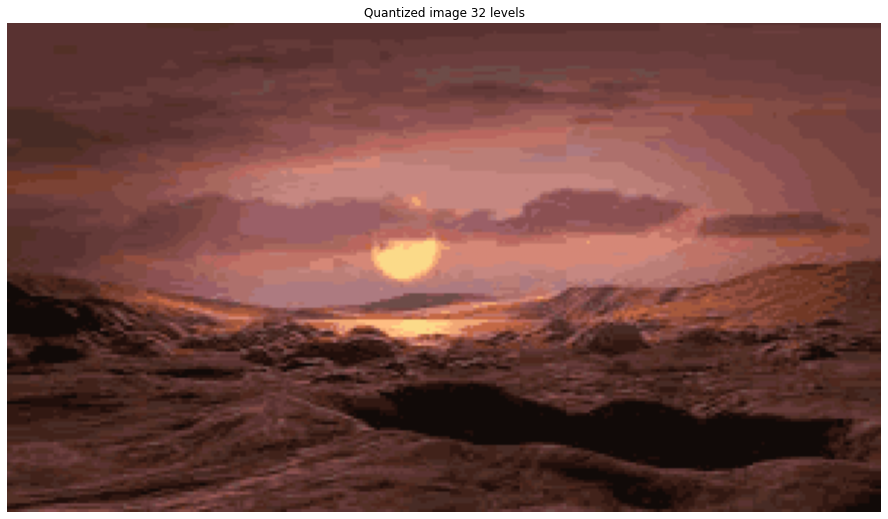

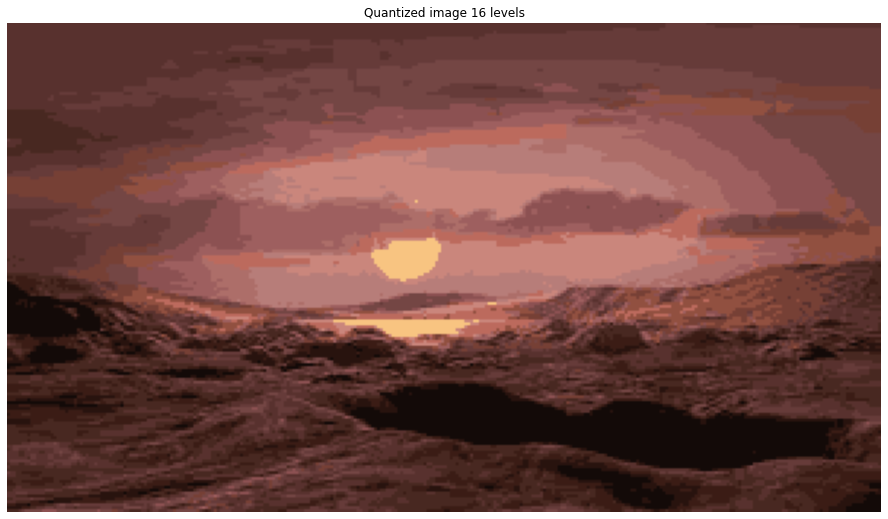

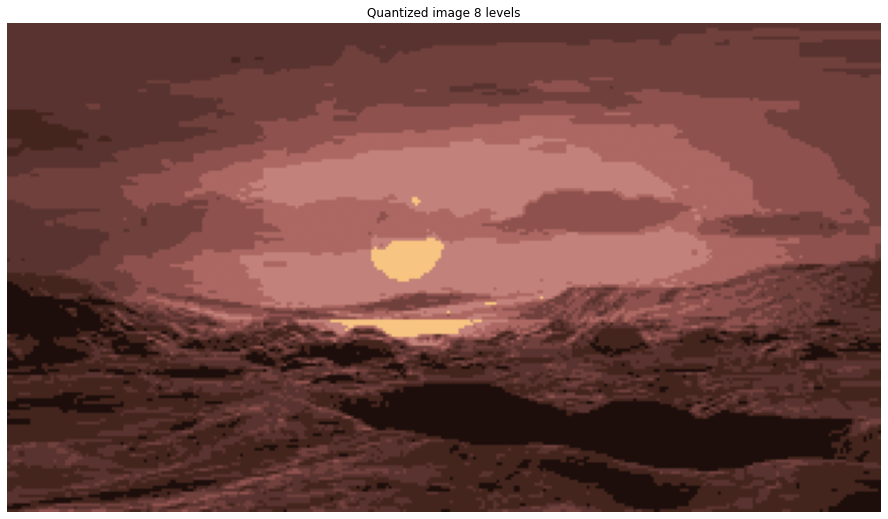

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io
from PIL import Image
from sklearn.cluster import KMeans
from skimage import data
image = data.chelsea()

def recreate_image(codebook, labels, w, h):
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image


N_COLORS = [64, 32, 16, 8]
SUBSAMPLE_SIZE = 0.01

from google.colab import files
uploaded = files.upload()
image = Image.open(io.BytesIO(uploaded['img.jpeg']))
image = np.array(image, dtype=np.float64) / 255

w, h, d = tuple(image.shape)
image_array = np.reshape(image, (w * h, d))
img_subsample = image_array[np.random.choice(w * h, int(w * h * SUBSAMPLE_SIZE)), :]

models = []
for colors in N_COLORS:
    kmeans = KMeans(n_clusters=colors).fit(img_subsample)
    models.append(kmeans)
    
plt.figure(figsize=(16,9))
plt.axis('off')
plt.title('Original image')
plt.imshow(image) 

for model in models:
    labels = model.predict(image_array)
    plt.figure(figsize=(16,9))
    plt.clf()
    plt.axis('off')
    plt.title(f'Quantized image {model.get_params().get("n_clusters")} levels')
    plt.imshow(recreate_image(model.cluster_centers_, labels, w, h))

## 2) Silhouette analysis

KMeans

For n_clusters = 2 The average silhouette_score is : 0.7678049780292223
For n_clusters = 3 The average silhouette_score is : 0.7308416071146798
For n_clusters = 4 The average silhouette_score is : 0.6071925763842486


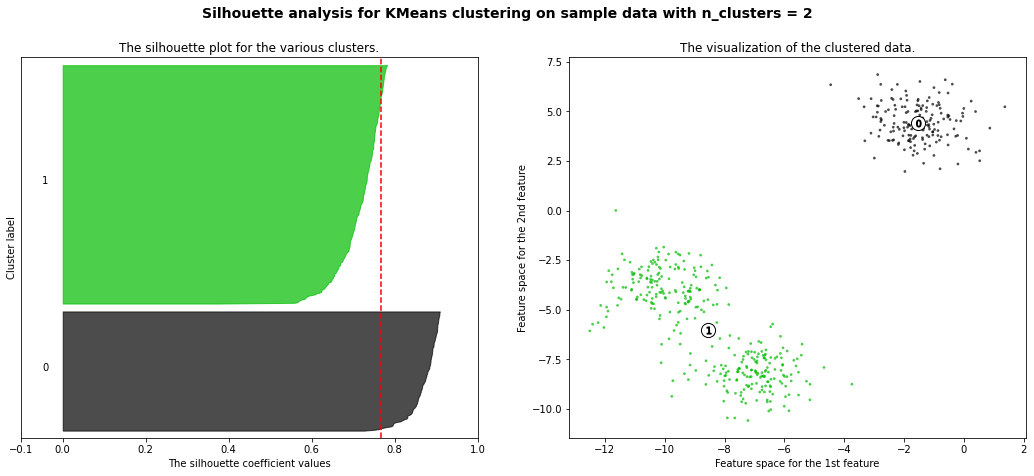

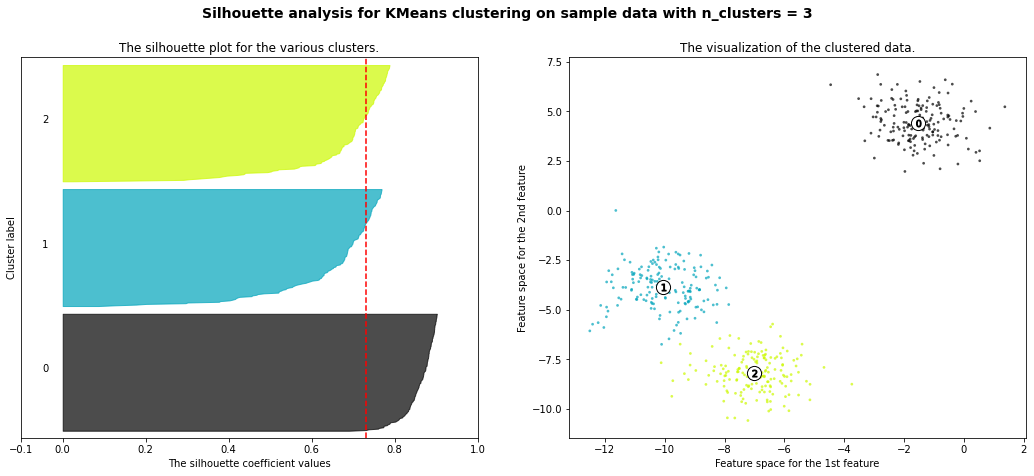

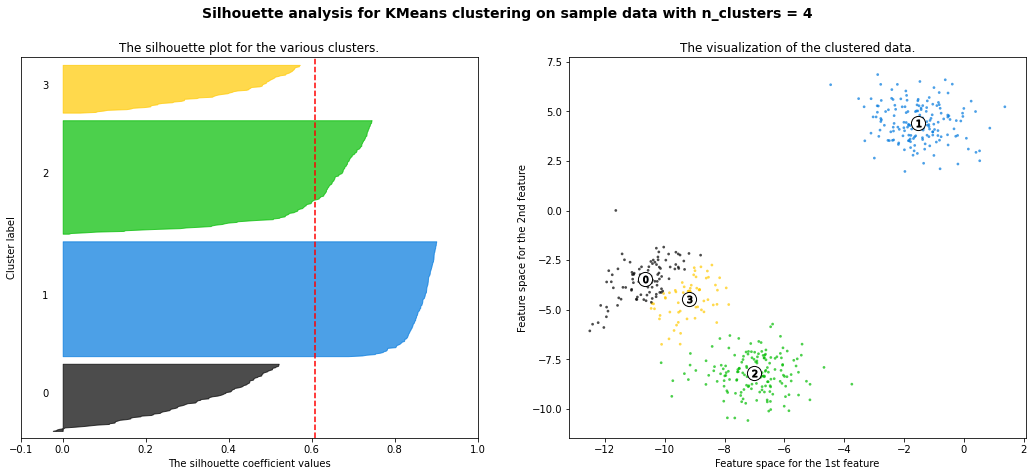

In [24]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=3,
                  shuffle=True,
                  random_state=1)

range_n_clusters = [2, 3, 4]

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])


    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

Silhouette аналіз може бути використаний для вивчення відстані поділу між отриманими скупченнями. Silhouette plot відображає міру того, наскільки кожна точка в одному кластері знаходиться близько до точок у сусідніх кластерах, і таким чином забезпечує спосіб візуальної оцінки таких параметрів, як кількість кластерів. В даному випадку видно що ні один з варіантів не виглядають однаково типово, так як в кластерах різної форми графіки розподілу silhouette coefficient. Також даних швидше за все не 4 кластерів, так як є кластер з silhouette coefficient сильно відрізнається за всіма даними, більш того, кластери сильно відрізняються за розмірами.

AgglomerativeClustering

In [25]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

In [26]:
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

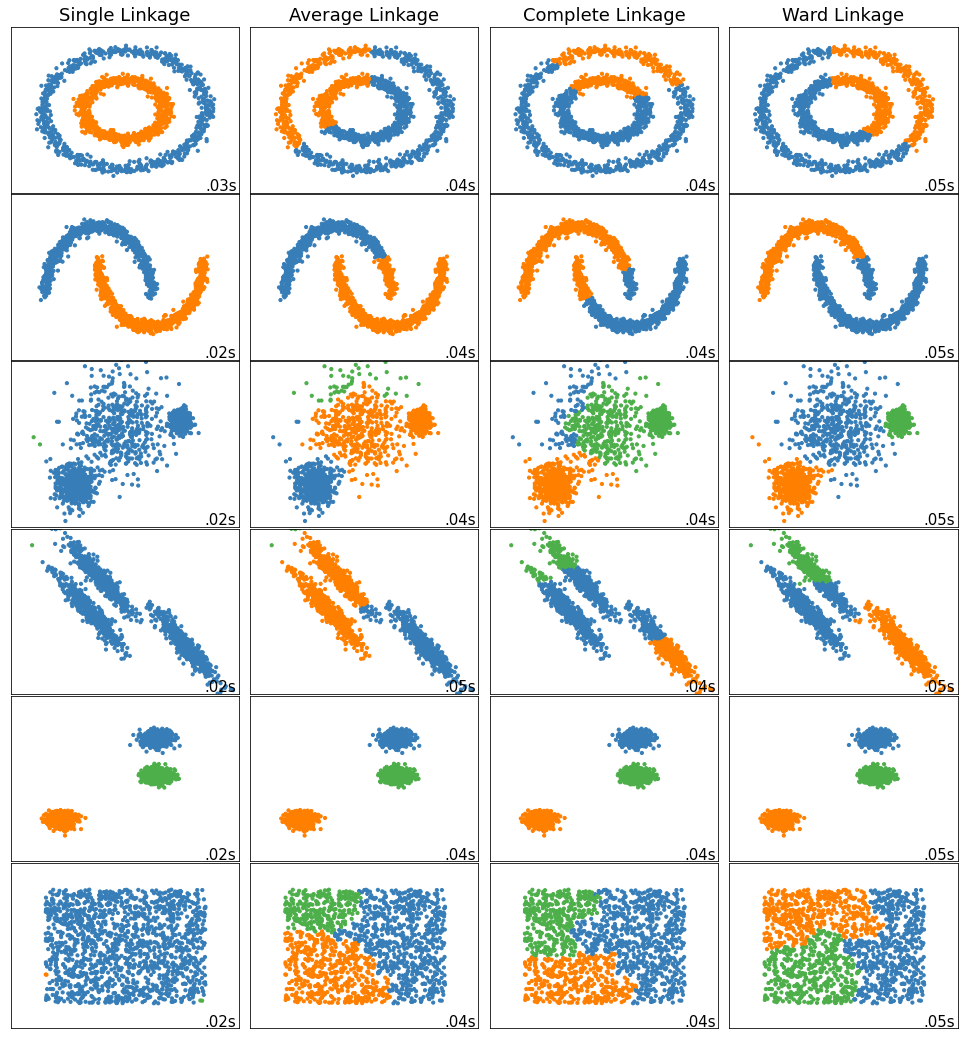

In [27]:
# Set up cluster parameters
plt.figure(figsize=(9 * 1.3 + 2, 14.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'n_neighbors': 10,
                'n_clusters': 3}

datasets = [
    (noisy_circles, {'n_clusters': 2}),
    (noisy_moons, {'n_clusters': 2}),
    (varied, {'n_neighbors': 2}),
    (aniso, {'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # ============
    # Create cluster objects
    # ============
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward')
    complete = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='complete')
    average = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='average')
    single = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='single')

    clustering_algorithms = (
        ('Single Linkage', single),
        ('Average Linkage', average),
        ('Complete Linkage', complete),
        ('Ward Linkage', ward),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

In [28]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering

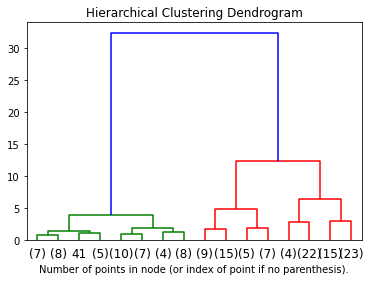

In [29]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


iris = load_iris()
X = iris.data

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

## 3) EM-algorithm

In [30]:
from sklearn.mixture import GaussianMixture
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

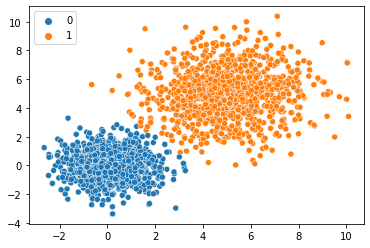

In [31]:
mean1 = [0, 0]
cov1 = [[1, 0],
        [0, 1]]

mean2 = [5, 5]
cov2 = [[3, 0],
        [0, 3]]


x1 = np.random.default_rng().multivariate_normal(mean1, cov1, 1000)
x2 = np.random.default_rng().multivariate_normal(mean2, cov2, 1000)
df = np.vstack([x1,x2])

gm = GaussianMixture(n_components=2, covariance_type='diag')
labels = gm.fit_predict(df)

sns.scatterplot(x=df[:,0], y=df[:,1], hue=labels)

### Recreating distributions

[0.96142743 0.98904653]


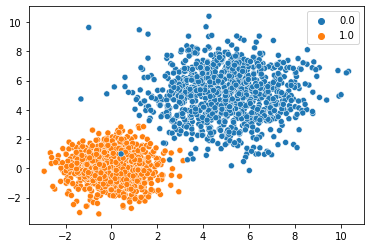

In [32]:
print(gm.covariances_[0])

x1 = np.random.default_rng().multivariate_normal(gm.means_[0], np.diag(gm.covariances_[0]), 1000)
x2 = np.random.default_rng().multivariate_normal(gm.means_[1], np.diag(gm.covariances_[1]), 1000)
df = np.vstack([x1,x2])

sns.scatterplot(x=df[:,0], y=df[:,1], hue=np.hstack([np.ones((1000)),np.zeros((1000))]))